In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [18]:
load_dotenv()
openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tool.invoke("LangGraph가 무엇인가요?")

[{'title': 'LangGraph란? - Dev studying blog - 티스토리',
  'url': 'https://dev-studyingblog.tistory.com/112',
  'content': 'LangGraph는 LangChain을 기반으로 만든 멀티에이전트 및 워크플로우 자동화 프레임워크이다. 쉽게 말해 AI 모델 간의 협업을 가능하게 하는 시스템',
  'score': 0.87981987},
 {'title': 'langgraph 소개 및 기본개념 : 네이버 블로그',
  'url': 'https://blog.naver.com/pjt3591oo/223861729229?fromRss=true&trackingCode=rss',
  'content': 'LangGraph는 LangChain 상태계의 일부로 LLM 애플리케이션의 흐름을 그래프로 정의하고 실행하는 라이브러리입니다. 여기서 그래프는 CS(Computer Science)',
  'score': 0.87807417}]

In [20]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [21]:
llm = ChatOpenAI(model=openai_model)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [22]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [23]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [24]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools)
workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
workflow.set_entry_point("chatbot")
graph = workflow.compile(checkpointer=memory)

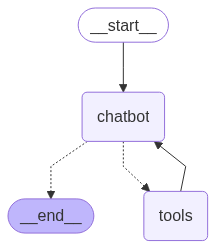

In [25]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "user123"}}

In [27]:
# 첫 번째 대화: 새로운 대화 맥락 생성
user_input1 = "LangGraph가 무엇인가요?"
state1 = {"messages": [HumanMessage(content=user_input1)]}
response1 = graph.invoke(state1, config)
# 챗봇의 첫 번째 응답 출력
print(response1["messages"][-1].content)

LangGraph는 복잡한 생성적 AI 에이전트 워크플로우를 구축, 배포 및 관리하기 위한 오픈 소스 AI 에이전트 프레임워크입니다. 이 프레임워크는 다양한 AI 에이전트 구성 요소 간의 관계를 모델링하고 관리하기 위해 그래프 기반 아키텍처를 사용합니다. LangGraph를 이용하면 사용자는 대형 언어 모델(LLM)을 효율적이고 확장 가능하게 생성, 실행 및 최적화할 수 있습니다.

### 주요 기능
1. **에이전트 시스템 구축**: LangGraph는 로봇 공학, 자율 차량, 비디오 게임 등 다양한 애플리케이션에서 사용될 수 있는 에이전트 기반 시스템 구축을 지원합니다.
2. **LLM 애플리케이션**: LangGraph의 기능을 활용하여 개발자는 시간이 지남에 따라 학습하고 개선되는 보다 정교한 AI 모델을 구축할 수 있습니다.
3. **상태 기계 모델**: Python 라이브러리로서 LangGraph는 챗봇이나 AI 에이전트를 단계별로 논리를 조직하여 애플리케이션의 동작을 정의하는 데 도움을 줍니다. 각 단계에서 입력을 분류하거나 응답을 생성하는 등의 작업을 수행하며, 애플리케이션은 정보를 공유 상태에 저장함으로써 진행 상황을 기억합니다.

자세한 내용은 [IBM의 설명](https://www.ibm.com/think/topics/langgraph)과 [GeeksforGeeks의 설명](https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/)에서 확인할 수 있습니다.


In [28]:
# 두 번째 대화: 이전 대화 맥락 유지
user_input2 = "그것을 만든 회사는 어딘가요?"
state2 = {"messages": [HumanMessage(content=user_input2)]}
response2 = graph.invoke(state2, config)
# 챗봇의 두 번째 응답 출력 (이전 대화의 맥락이 유지된 상태)
print(response2["messages"][-1].content)

LangGraph는 **LangChain**이라는 회사에 의해 개발되었습니다. LangChain은 주로 자연어 처리 및 AI 모델 생성을 위한 도구와 프레임워크를 제공하는 회사입니다. LangGraph는 이 회사가 제공하는 솔루션 중 하나로, 복잡한 AI 에이전트 워크플로우를 효율적으로 관리하고 구축하는 데 중점을 두고 있습니다.


In [29]:
# 세 번째 대화: 새로운 thread_id 사용하여 독립된 새로운 대화 맥락 생성
user_input3 = "그것을 만든 회사는 어딘가요?"
state3 = {"messages": [HumanMessage(content=user_input3)]}
response3 = graph.invoke(state3, {"configurable": {"thread_id": "user456"}})
# 새로운 대화 맥락에서의 챗봇 응답 출력 (기존 thread_id와 독립된 상태)
print(response3["messages"][-1].content)

더 많은 정보가 필요합니다. "그것"이 어떤 것을 의미하는지 구체적으로 말씀해 주실 수 있나요?


In [30]:
# 기존 thread_id의 대화 상태 확인
snapshot = graph.get_state(config)
snapshot.values['messages']

[HumanMessage(content='LangGraph가 무엇인가요?', additional_kwargs={}, response_metadata={}, id='cd2cf056-10cd-4862-bda9-43476999a4b2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9a4ZKd6WEdNHt5DX3QmpcmXw', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 86, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnIkjNMY0Jgwa8aqUoxMZiF5lvr9S', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ca799ffc-d291-4625-94ee-63b5e262211f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'

In [31]:
# 새 thread_id의 대화 상태 확인
graph.get_state({"configurable": {"thread_id": "user456"}}).values['messages']

[HumanMessage(content='그것을 만든 회사는 어딘가요?', additional_kwargs={}, response_metadata={}, id='74f8c202-5f9d-4663-959c-a556d91780a5'),
 AIMessage(content='더 많은 정보가 필요합니다. "그것"이 어떤 것을 의미하는지 구체적으로 말씀해 주실 수 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 91, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnIksxsu7EKmibkunpXi1PLdYIHoB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4e9ce209-4389-458c-a8d6-ea0dad3e2bc8-0', usage_metadata={'input_tokens': 91, 'output_tokens': 29, 'total_tokens': 120, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [32]:
from pprint import pprint
# 체크포인터가 MemorySaver일 경우 예시
all_snapshots = memory.list({})  # 모든 thread_id 상태 조회
for snapshot in all_snapshots:
    print(snapshot.config['configurable']['thread_id'])
    if 'messages' in snapshot.checkpoint['channel_values']:
        pprint(snapshot.checkpoint['channel_values']['messages'])
    else:
        print("No messages found in this snapshot.")

user123
[HumanMessage(content='LangGraph가 무엇인가요?', additional_kwargs={}, response_metadata={}, id='cd2cf056-10cd-4862-bda9-43476999a4b2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9a4ZKd6WEdNHt5DX3QmpcmXw', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 86, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnIkjNMY0Jgwa8aqUoxMZiF5lvr9S', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ca799ffc-d291-4625-94ee-63b5e262211f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'La